In [1]:
using Flux
using Images
using Plots

In [2]:
using BSON
using Random

In [3]:
using Parameters

In [4]:
@with_kw struct HyperParameters
	batch_size::Int = 128
	latent_dim::Int = 100
	epochs::Int = 20
	verbose_freq::Int = 1000
	output_x::Int = 10    # for visualization of generator
	output_y::Int = 10    # for visualization of generator
	αᴰ::Float64 = 0.0002 # discriminator learning rate
	αᴳ::Float64 = 0.0002 # generator learning rate
    device::Function = cpu # device to send operations to. Can be cpu or gpu
    
    # Generator architecture parameters - default 128, 128, 64
    latent_channels::Int = 128
    conv_1_channels::Int = 128
    conv_2_channels::Int = 64
end

struct Generator
    # Submodel to take labels as input and convert it to the shape of (3, 5, 1, batch_size)
    g_labels          
    # Submodel to take latent_dims as input and convert it to shape of (3, 5, 128, batch_size)
    g_latent          
    g_common
end

function Generator(hp::HyperParameters)
    latent_im_nodes = 3*5
    g_labels = Chain(Dense(2, latent_im_nodes), x-> reshape(x, 3, 5, 1 , size(x, 2))) |> hp.device
    g_latent = Chain(Dense(hp.latent_dim, hp.latent_channels * latent_im_nodes), 
            x-> leakyrelu.(x, 0.2f0), 
            x-> reshape(x, 3, 5, hp.latent_channels, size(x, 2))) |> hp.device
    g_common = Chain(ConvTranspose((3, 3), hp.latent_channels+1=>hp.conv_1_channels; stride=2, pad=1),
            BatchNorm(hp.latent_channels, leakyrelu),
            Dropout(0.25),
            ConvTranspose((4, 4), hp.conv_1_channels=>hp.conv_2_channels; stride=2, pad=1),
            BatchNorm(64, leakyrelu),
            Conv((7, 7), hp.conv_2_channels=>1, tanh; stride=1, pad=3)) |> hp.device
    return Generator(g_labels, g_latent, g_common)
end

function (m::Generator)(x, y)
    t = cat(m.g_labels(y), m.g_latent(x), dims=3)
    return m.g_common(t)
end

In [80]:
GAN_fn = "pendulum_GAN_latent2.bson"
res = BSON.load(GAN_fn)
G_conv = res[:G_conv]
testmode!(G_conv);

In [6]:
noise = [randn(1) for i = 1:21]
labels = [[i, 0] for i = deg2rad.(-20:2:20)];

In [7]:
images = G_conv.(noise, labels);

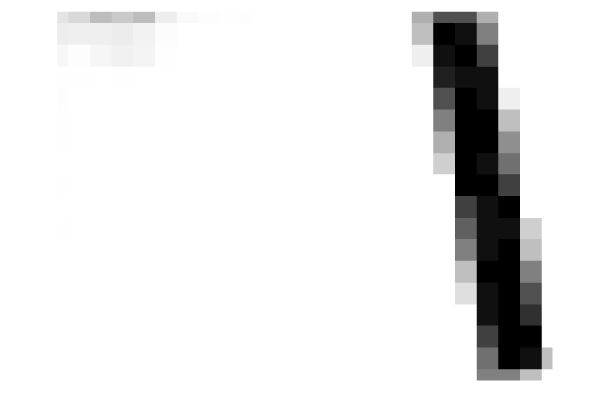

In [12]:
img = images[6]
img = img[:,:,1,1]
plot(plot(Gray.(img' .+ 1f0) / 2f0, axis = ([], false)),
    plot(Gray.(simple_render_pendulum([deg2rad(10), 0])'), axis = ([], false)))

In [9]:
include("../simple_render.jl")

downsample (generic function with 1 method)

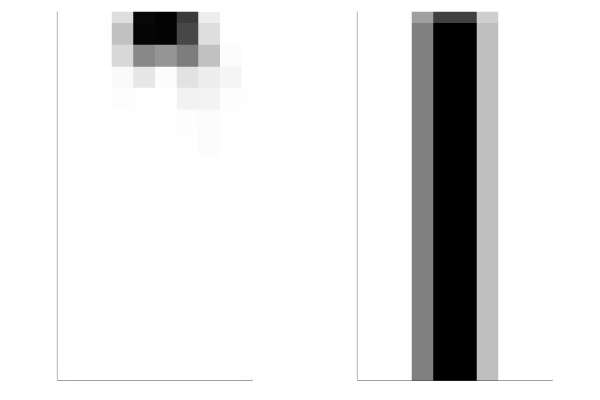

In [89]:
θ = deg2rad(0)
ω = 0

noise = randn(2)
labels = [θ / deg2rad(22), ω / 8]

img = G_conv(noise, labels)

img = img[:,:,1,1]
p = plot(plot(Gray.(img' .+ 1f0) / 2f0, axis = ([])),
    plot(Gray.(simple_render_pendulum([θ, ω])'), axis = ([])))

In [83]:
fn = "/scratch/smkatz/NASA_ULI/pendulum_GAN_data.bson"

"/scratch/smkatz/NASA_ULI/pendulum_GAN_data.bson"

In [30]:
res = BSON.load(fn)
timages = res[:images];

In [37]:
timages[:,:,7]

10×18 Array{Float32,2}:
 1.0      1.0      1.0      1.0     …  1.0     1.0   0.8125  0.6875  1.0
 1.0      1.0      1.0      1.0        0.25    0.0   0.0625  0.0625  0.5
 1.0      1.0      1.0      0.875      0.0625  0.0   0.0625  0.0625  0.25
 0.5      0.25     0.0625   0.0625     0.0     0.25  0.375   0.5     0.75
 0.3125   0.0      0.0      0.0        1.0     1.0   1.0     1.0     1.0
 0.28125  0.0      0.25     0.375   …  1.0     1.0   1.0     1.0     1.0
 0.59375  0.65625  1.0      1.0        1.0     1.0   1.0     1.0     1.0
 0.65625  0.53125  1.0      1.0        1.0     1.0   1.0     1.0     1.0
 0.65625  0.53125  0.90625  1.0        1.0     1.0   1.0     1.0     1.0
 0.65625  0.5      0.78125  1.0        1.0     1.0   1.0     1.0     1.0